# Build a grid for ASL locations
In this tutorial we build a grid to use for Montserrat amplitude-source-location (ASL)

We build a rectangular grid, that will be our base Grid() object

We can make this in various ways, so that not all nodes will be used for ASL. For example, we can mask out nodes in the sea.

We can also make circular masks, to mask out all nodes further than 1 km from the dome.

We can also mask out nodes that are not in streams.

By combining masks, we can reduce a rectangular grid to just land nodes that are in streams, or within 1 km of the dome. This might be what we want to use for ASL for Montserrat.

# 1. Imports and globals
Note that here we set a DEFAULT DEM, REGION, and INV

In [3]:
import os
from pathlib import Path
import itertools
from datetime import datetime

import numpy as np
from obspy import read_inventory

from flovopy.asl.map import topo_map  
from flovopy.asl.grid import make_grid, Grid, _meters_per_degree,  apply_channel_land_circle_mask

# --- Project inputs you already have somewhere else ---
PROJECTDIR = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
INVENTORY_XML = f"/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")

# I/O
INPUT_DIR = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_notebooks"

DIST_MODE = "3d"        # include elevation\
GLOBAL_CACHE = f"{PROJECTDIR}/asl_global_cache"
OUTPUT_DIR = GLOBAL_CACHE

# Montserrat default region (lon_min, lon_max, lat_min, lat_max)
from flovopy.core.mvo import REGION_DEFAULT, dome_location
print(REGION_DEFAULT)
print(dome_location)

# Load inventory once
INV = read_inventory(INVENTORY_XML)


(-62.255, -62.135, 16.66, 16.84)
{'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}


## 2.1 Setting up a base map
To make it easier to create a base topo_map(), we can define a dictionary called topo_kw with keyword arguments we want to use, and then pass this using keyword expansion (**topo_kw)

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


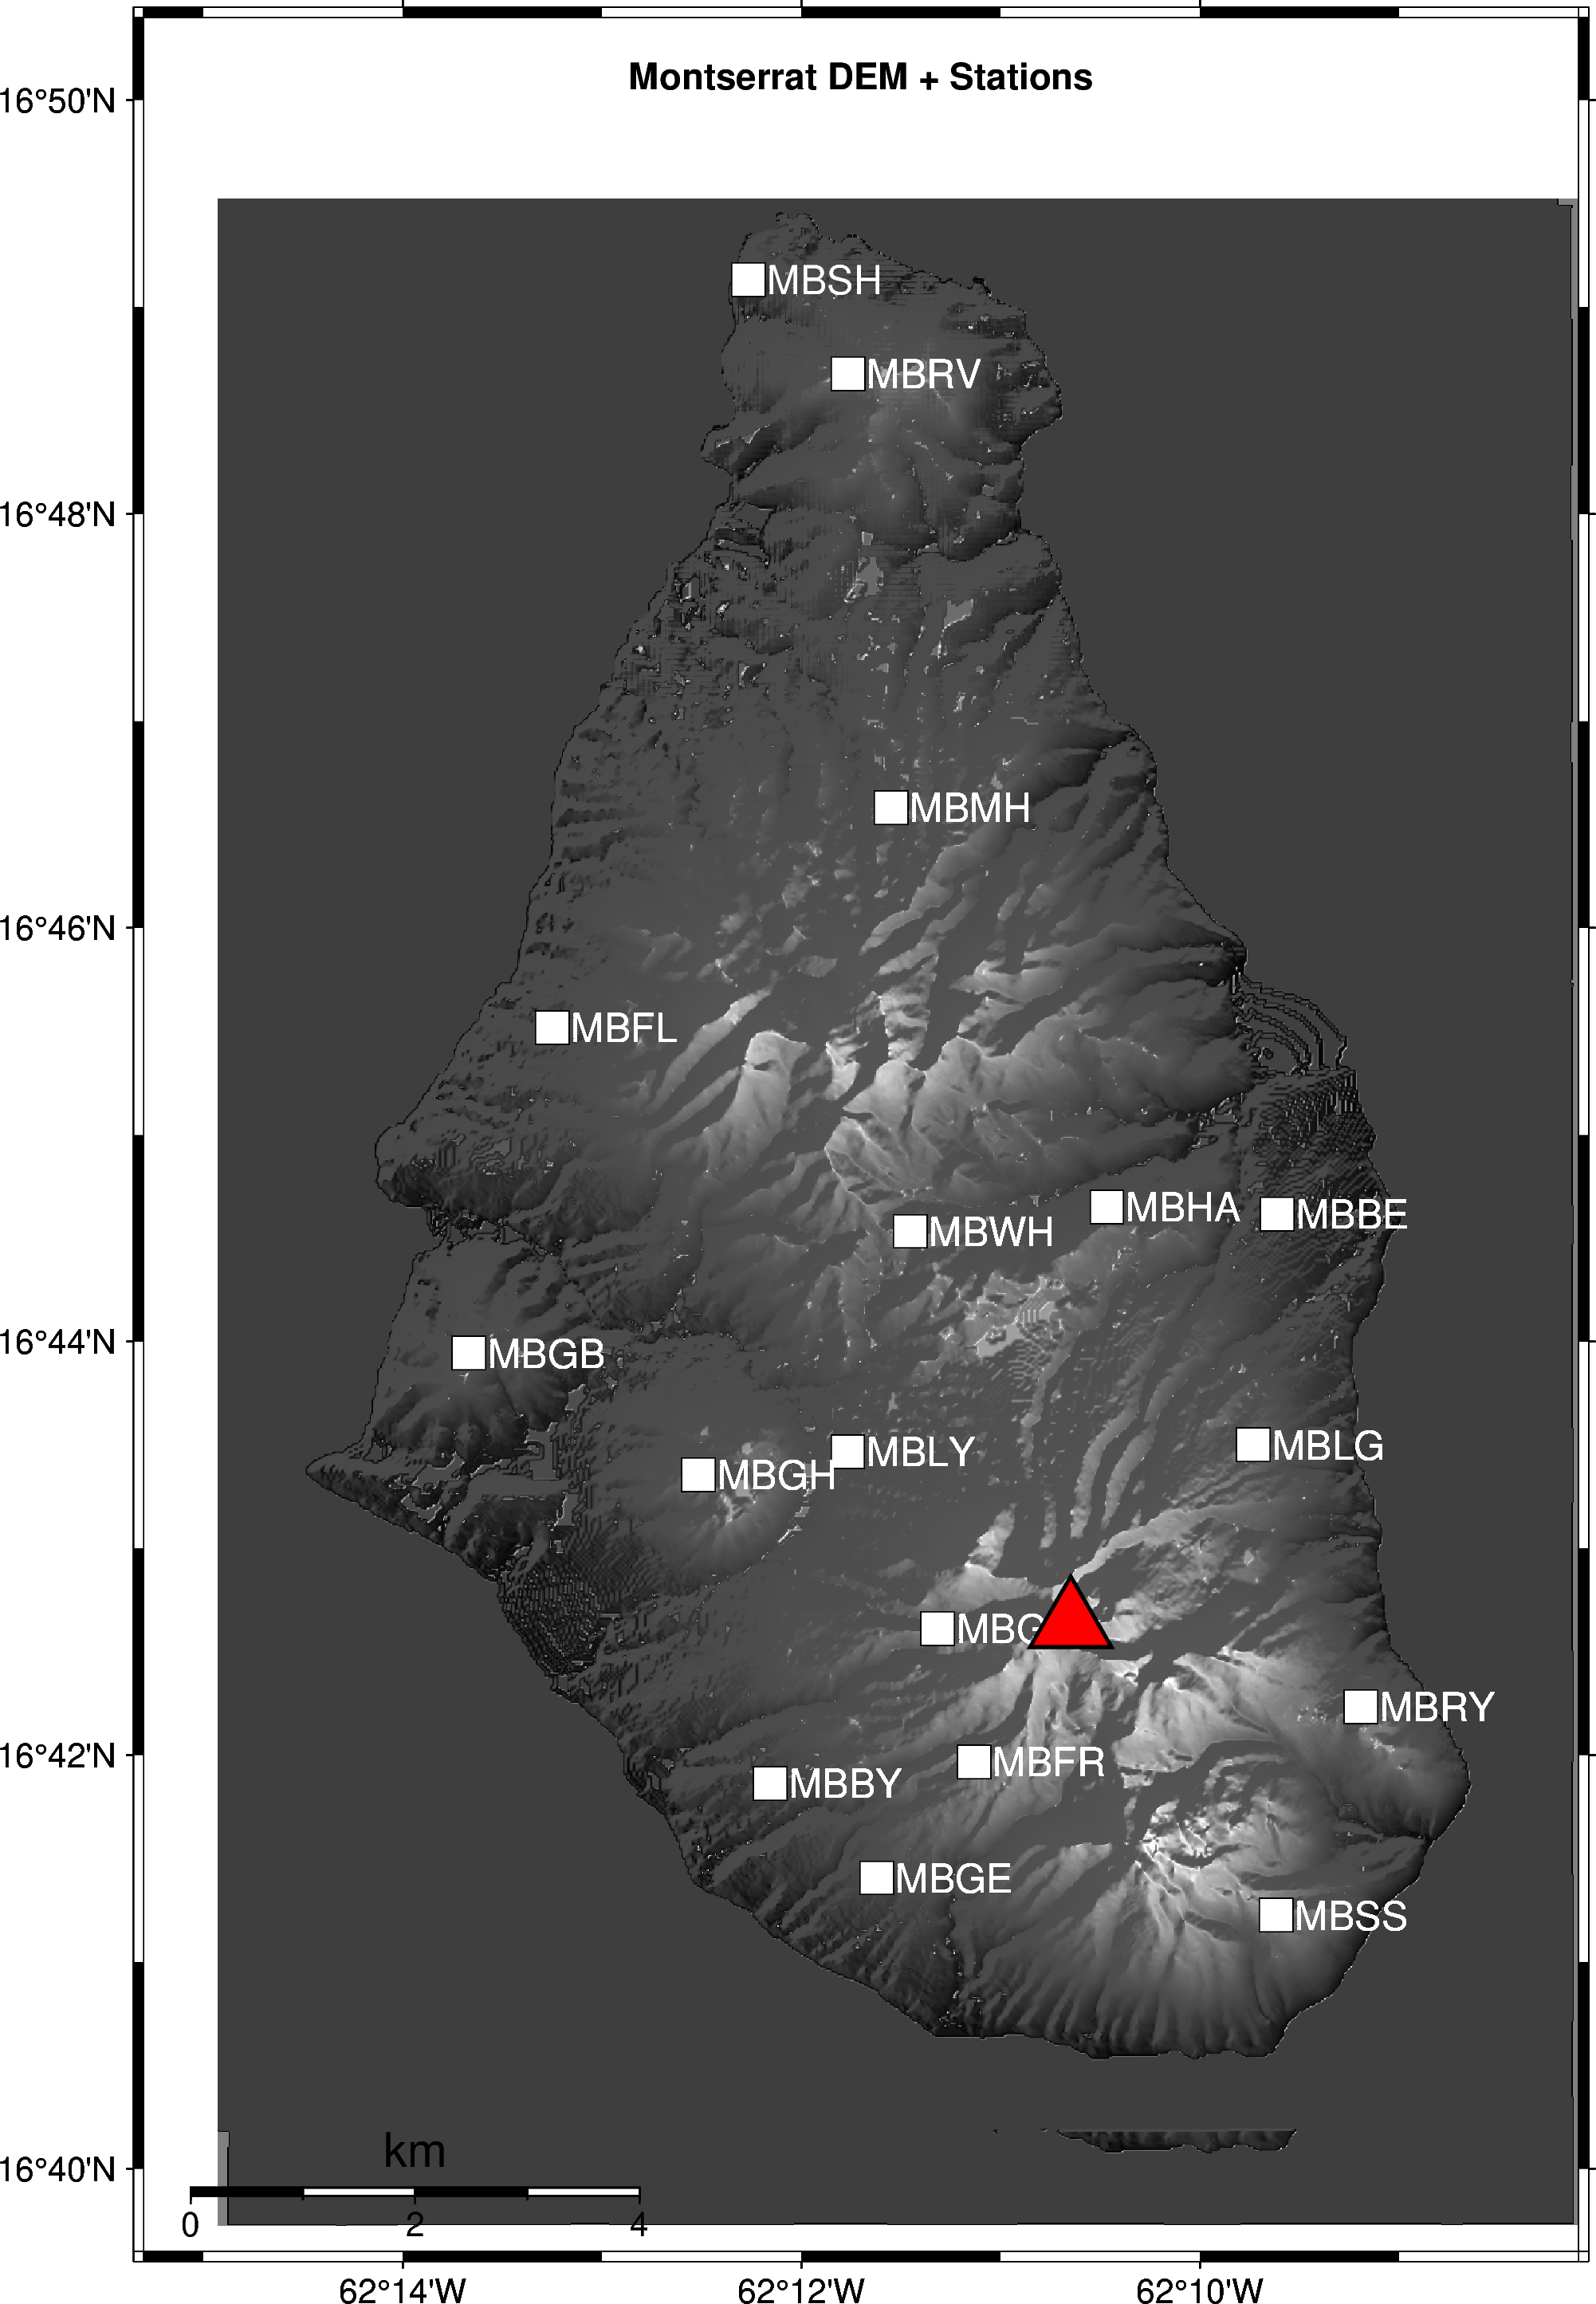

In [4]:
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "title": "Montserrat DEM + Stations",
    "frame": True,
    "dome_location": dome_location,
}
fig = topo_map(show=True,**topo_kw)

# 2.2 Construct rectangular grid 10.5 km x 8.3 km with 10-m spacing
Build regular grid, shown as a red box.

In [ ]:
# define grid size and spacing
GRID_SIZE_LAT_M = 8_300   
GRID_SIZE_LON_M = 10_500  
NODE_SPACING_M  = 10       

# if we want to create a 3-D grid draped on topography, we need to provide a DEM
dem_spec = ("geotiff", {"path": DEM_DEFAULT, "tag": os.path.basename(DEM_DEFAULT)})
#dem_spec = ("pygmt", {"resolution": "01s"})  # or "01s" # default Pygmt DEM

# since this grid can take several minutes to create, we will cache it on disk. 
rectgrid_cache_dir = f"{GLOBAL_CACHE}/rectangular_optimal"
gridfile = os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl')

if os.path.isfile(gridfile):
    # Grid object already exists in cache, so just load it.
    gridobj = Grid.load(gridfile)
else:
    # Create the Grid object
    gridobj = make_grid(
        center_lat=dome_location["lat"],
        center_lon=dome_location["lon"]-0.017,
        node_spacing_m=NODE_SPACING_M,
        grid_size_lat_m=GRID_SIZE_LAT_M,
        grid_size_lon_m=GRID_SIZE_LON_M,
        dem=dem_spec,
    )
    
    # Save (cache) the Grid object, so we do not have to create it next time
    gridobj.save(cache_dir = rectgrid_cache_dir, force_overwrite = False)


print(gridobj)

# Plot the grid object - when points are dense, a red polygon boundary is shown only
gridpng = gridfile.replace('.pkl', '.png')
gridobj.plot(show=True, min_display_spacing=300, scale=2.0, outfile=gridpng, topo_map_kwargs=topo_kw);


## 2.3 Use a land mask to change the rectangular grid

In [ ]:
# Load the rectangular grid from cache
gridobj = Grid.load(os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl'))

# Apply a simple land mask - all nodes below sea level will be masked
land_mask = gridobj.apply_land_mask_from_dem(sea_level=0.0)

# Count how many nodes are still unmasked - and therefore usable by ASL
kept_land = int(land_mask.sum())
print(f"[LAND MASK] kept {kept_land}/{gridobj.gridlat.size} nodes ({100*kept_land/gridobj.gridlat.size:.1f}%)")

print(gridobj)

# Cache this land-masked grid
landgrid_cache_dir = f"{GLOBAL_CACHE}/land"
gridobj.save(cache_dir = landgrid_cache_dir, force_overwrite = False)

# Plot it
gridpng = str(Path(landgrid_cache_dir) / "grid.png")
gridobj.plot(show=True, scale=2.0, outfile=gridpng, topo_map_kwargs=topo_kw)#, force_all_nodes=True);

# Plot it again, but rather than plot the boundary, let's force it to plot all the nodes
gridobj.plot(show=True, scale=2.0, topo_map_kwargs=topo_kw, force_all_nodes=True)


## 2.4 Circular mask, radius 1 km around dome

In [ ]:
# let's reload the rectangular grid we just created
gridobj = Grid.load(os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl'))

MASK_RADIUS_KM  = 1.0 
m_per_deg_lat, m_per_deg_lon = _meters_per_degree(gridobj.centerlat)

# for each node, compute the distance north-south from the dome
dlat_m = (gridobj.gridlat - dome_location['lat']) * m_per_deg_lat

# for each node, compute the distance east-west from the dome
dlon_m = (gridobj.gridlon - dome_location['lon']) * m_per_deg_lon

# for each node compute the 2-D distance
dist_m = np.hypot(dlat_m, dlon_m)

# create a mask where nodes within 1 km are True, nodes further away are False
circle_mask = dist_m <= (MASK_RADIUS_KM * 1000.0)

# count how many nodes fall are within the circle (i.e. how many True values in circle_mask)
kept_circle = int(circle_mask.sum())
print(f"[CIRCLE MASK] kept {kept_circle}/{gridobj.gridlat.size} nodes ({100*kept_circle/gridobj.gridlat.size:.1f}%)")

# apply this mask to the rectangular grid - this changes the gridobj
gridobj.apply_mask_boolean(circle_mask)
print(gridobj)

# save the new grid
circgrid_cache_dir = f"{GLOBAL_CACHE}/circle"
gridobj.save(cache_dir = circgrid_cache_dir, force_overwrite = False)

# plot the new grid
gridpng = str(Path(circgrid_cache_dir) / "grid.png")
gridobj.plot(show=True, min_display_spacing=300, scale=2.0, outfile=gridpng, topo_map_kwargs=topo_kw);

# 2.5 Combine these masks in an unusual way
Here we take the land mask and perform a logical AND with nodes NOT in the circle

In [ ]:
# Load the rectangular Grid
gridobj = Grid.load(os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl'))

# Combine the masks
combined = ~circle_mask & land_mask

# Apply mask to the Grid object
gridobj.apply_mask_boolean(combined)
kept = int(combined.sum())
print(f"[COMBINED MASK] kept {kept}/{gridobj.gridlat.size} nodes ({100*kept_land/gridobj.gridlat.size:.1f}%)")
print(gridobj)

# Plot the new grid
gridobj.plot(show=True, force_all_nodes=True, scale=2.0, topo_map_kwargs=topo_kw);


# 2.6 Creating a grid from (water) stream channels
Background:
- A separate code called channel_finder.sh in flovopy.dem constructed a NodeGrid() object of water stream channels from the 1999 Montserrat DEM.
- That DEM itself was constructed with detect_scaling_CRS.py, as the source x-y-z file, probably from Surfer, had no georeference, so we tried to detect it.
- We also shifted it - see topo_map() tutorial

Here we load that NodeGrid. It is far from a perfect representation of channels - that logic needs to be improved.

We convert the NodeGrid into a Grid() object using the mask_grid_with_nodes() method of NodeGrid().



In [ ]:
from pathlib import Path
import pickle 

# Load rectangular Grid
gridobj = Grid.load(os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl'))

# Load the NodeGrid of channel nodes - these are not fixed to a regularly sampled grid, but are along channels
with open('/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/channel_finder/NodeGrid_58bc3f4e.pkl','rb') as f:
    nodegrid = pickle.load(f)

# Mask based on NodeGrid → nearest horizontal neighbors in the Grid
channels_grid, mask2d, matches = nodegrid.mask_grid_with_nodes(
    gridobj,
    k=4,
    max_m=20.0,
    flatten_copy=True,
    mask_name="channels_only",
    return_matches=True,
)

# Summarize
print(matches.head())
print("[CHANNELS MASK] kept nodes:", mask2d.sum(), "of", mask2d.size)
print(channels_grid)

# Cache this Grid() that has been masked with channels
channelsgrid_cache_dir = f"{GLOBAL_CACHE}/channels"
#channels_grid.save(cache_dir = channelsgrid_cache_dir, force_overwrite = False)

# Plot the channels Grid()
gridpng = str(Path(channelsgrid_cache_dir) / "grid.png")

# If your Grid supports plotting masks:
channels_grid.plot(
    topo_map_kwargs=topo_kw,
    symbol="c", scale=2.0, fill="red", force_all_nodes=True, show=True,
);


# 3. Creating a Montserrat Grid for channels on land only, plus the dome

In [5]:
# Reload rectangular grid
import pickle
rectgrid_cache_dir = f"{GLOBAL_CACHE}/rectangular_optimal"
gridfile = os.path.join(rectgrid_cache_dir, 'Grid_2e0bce30.pkl')
gridobj = Grid.load(gridfile)
channels_nodegrid = '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/channel_finder6/NodeGrid_89d0488d.pkl'

# Reload NodeGrid of channels
with open(channels_nodegrid,'rb') as f:
    nodegrid = pickle.load(f)

# Apply channel and land masks, then add back in everything in the circle
final_grid = apply_channel_land_circle_mask(
    gridobj,
    nodegrid,
    k=4,
    max_m=20.0,
    dome_location=dome_location,
    radius_km=1.0,
)

# Summarize
print(final_grid)

# Cache
finalgrid_cache_dir = f"{GLOBAL_CACHE}/final"
final_grid.save(cache_dir = finalgrid_cache_dir, force_overwrite = True)

# Plot
gridpng = str(Path(finalgrid_cache_dir) / "grid.png")
#gridobj.plot(show=True, force_all_nodes=True, scale=2.0, outfile=gridpng, topo_map_kwargs=topo_kw);

# If your Grid supports plotting masks:
final_grid.plot(
    topo_map_kwargs=topo_kw,
    symbol="c", scale=2.0, fill="red", force_all_nodes=True, show=True,
);

FileNotFoundError: No such file: /Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver/asl_global_cache/rectangular_optimal/Grid_2e0bce30.pkl